In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [53]:
TrainData = pd.read_csv("NASADataset/train_FD001.txt", sep=r"\s+", header=None)
TestData = pd.read_csv("NASADataset/test_FD001.txt", sep=r"\s+", header=None)
RUL = pd.read_csv("NASADataset/RUL_FD001.txt", header=None)


# column headers based on kaggle
headers = [
    "engine_id", "cycle", "setting1", "setting2", "setting3",
    "sensor1", "sensor2", "sensor3", "sensor4", "sensor5",
    "sensor6", "sensor7", "sensor8", "sensor9", "sensor10",
    "sensor11", "sensor12", "sensor13", "sensor14", "sensor15",
    "sensor16", "sensor17", "sensor18", "sensor19", "sensor20", "sensor21"
]
TrainData.columns = headers
TestData.columns = headers



In [54]:
# 1. Add RUL to training data
TrainData['RUL'] = TrainData.groupby('engine_id')['cycle'].transform("max") - TrainData['cycle']
TrainData = TrainData.sort_values(by=['engine_id', 'cycle'])
TestData = TestData.reset_index(drop=True)

# Map engine_id (1-indexed) to raw RUL values from RUL_FD001.txt
rul_mapping = dict(zip(RUL.index + 1, RUL[0]))  # RUL_FD001.txt uses 1-based indexing
TestData['RUL'] = TestData['engine_id'].map(rul_mapping)

TestData = TestData.sort_values(by=['engine_id', 'cycle'])

scaler = StandardScaler()
sensor_columns = headers[2:]  # All sensor data columns
TrainData[sensor_columns] = scaler.fit_transform(TrainData[sensor_columns])
TestData[sensor_columns] = scaler.transform(TestData[sensor_columns])

# 4. Create sliding window sequences and track test windows
def create_sequences_with_windows(data, target, sequence_length, sensor_columns):
    sequences, targets, num_windows_list = [], [], []
    for engine_id, group in data.groupby('engine_id'):
        sensor_data = group[sensor_columns].values
        rul = group[target].values
        num_windows = len(sensor_data) - sequence_length + 1
        if num_windows > 0:  # Ensure at least one sequence can be created
            num_windows_list.append(num_windows)
            for i in range(num_windows):
                sequences.append(sensor_data[i:i + sequence_length])
                targets.append(rul[i + sequence_length - 1])
    return np.array(sequences), np.array(targets), num_windows_list

# Update training and validation sequence creation
sequence_length = 60  # Set appropriate sequence length
X_train, y_train, _ = create_sequences_with_windows(TrainData, 'RUL', sequence_length, sensor_columns)
X_val, y_val, num_test_windows_list = create_sequences_with_windows(TestData, 'RUL', sequence_length, sensor_columns)

# Convert num_test_windows_list to NumPy array for easier processing
num_test_windows_list = np.array(num_test_windows_list)

#Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)

# TestData alignment with RUL_FD001.txt
print("Sample of TestData['RUL']:", TestData[['engine_id', 'cycle', 'RUL']].tail())
print("Sample of TestData['RUL']:", TestData[['engine_id', 'cycle', 'RUL']].head())
print("Sample of RUL_FD001.txt:", RUL.head())


Training Data Shape: (14731, 60, 24) (14731,)
Validation Data Shape: (7351, 60, 24) (7351,)
Sample of TestData['RUL']:        engine_id  cycle  RUL
13091        100    194   20
13092        100    195   20
13093        100    196   20
13094        100    197   20
13095        100    198   20
Sample of TestData['RUL']:    engine_id  cycle  RUL
0          1      1  112
1          1      2  112
2          1      3  112
3          1      4  112
4          1      5  112
Sample of RUL_FD001.txt:      0
0  112
1   98
2   69
3   82
4   91


0        1
1        2
2        3
3        4
4        5
      ... 
187    188
188    189
189    190
190    191
191    192
Name: cycle, Length: 192, dtype: int64
[np.int64(362), np.int64(341), np.int64(336), np.int64(313), np.int64(293), np.int64(287), np.int64(283), np.int64(283), np.int64(278), np.int64(276), np.int64(275), np.int64(269), np.int64(267), np.int64(259), np.int64(258), np.int64(257), np.int64(256), np.int64(240), np.int64(240), np.int64(234), np.int64(234), np.int64(231), np.int64(231), np.int64(231), np.int64(230), np.int64(229), np.int64(222), np.int64(217), np.int64(216), np.int64(215), np.int64(214), np.int64(214), np.int64(213), np.int64(213), np.int64(213), np.int64(213), np.int64(213), np.int64(210), np.int64(209), np.int64(208), np.int64(207), np.int64(207), np.int64(202), np.int64(202), np.int64(202), np.int64(201), np.int64(200), np.int64(200), np.int64(199), np.int64(199), np.int64(199), np.int64(198), np.int64(196), np.int64(195), np.int64(195), np.int64(195),

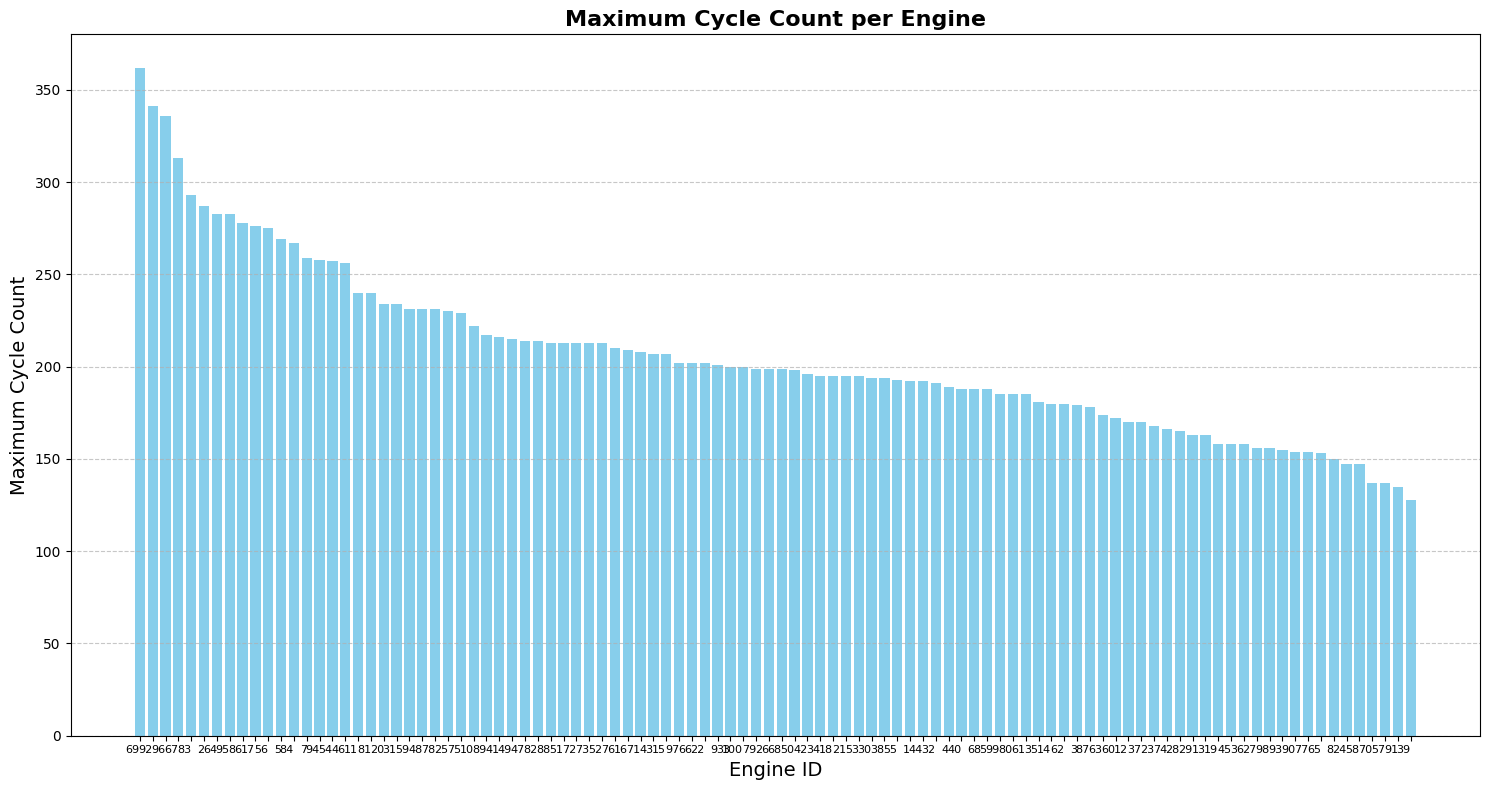

In [55]:
#Calculating maximum cycles per engine 
CT = TrainData[['engine_id', 'cycle']].groupby("engine_id")
CT = CT.max().sort_values(by="cycle", ascending=False)
engine_1_cycles = TrainData[TrainData['engine_id'] == 1]['cycle']
print(engine_1_cycles)
index = [str(i) for i in CT.index.to_list()]
values = list(CT.cycle.values)
print(values)
# Bar plot
plt.figure(figsize=(15, 8))  # Increased figure size for better spacing
plt.bar(index, values, color='skyblue')

#abels and title
plt.xlabel('Engine ID', fontsize=14)
plt.ylabel('Maximum Cycle Count', fontsize=14)
plt.title('Maximum Cycle Count per Engine', fontsize=16, fontweight='bold')
plt.xticks(fontsize=8, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [56]:
class RULPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(RULPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Use last time step
        lstm_out = self.batch_norm(lstm_out)  # Apply batch normalization
        return self.fc(lstm_out)


In [57]:
# Hyperparameters
input_dim = 24  # Number of sensor features
hidden_dim = 64
num_layers = 2
output_dim = 1
dropout = 0.6
learning_rate = 0.0001
epochs = 50

model = RULPredictor(input_dim, hidden_dim, num_layers, output_dim, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.MSELoss()




In [58]:


# Add noise to training data
noise = np.random.normal(0, 0.005, TrainData[sensor_columns].shape)  # Decrease noise scale
TrainData[sensor_columns] += noise

# Optimizer with reduced learning rate and regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)


# Scheduler for dynamic learning rate adjustment
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


epochs = 50
patience = 10  # Early stopping patience
best_val_loss = float('inf')
counter = 0

# Set the number of gradient accumulation steps
accumulation_steps = 4

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred.squeeze(), y_batch) / accumulation_steps  # Divide loss by accumulation steps
        loss.backward()

        # Update gradients and optimizer step after every 'accumulation_steps'
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Gradient clipping
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps  # Multiply back to track the actual loss value
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    all_y_pred = [] 
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            all_y_pred.append(y_pred.cpu().numpy()) 
            loss = loss_fn(y_pred.squeeze(), y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    all_y_pred = np.concatenate(all_y_pred, axis=0) 
    # Update scheduler based on validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/50, Train Loss: 6788.8672, Val Loss: 1512.2466
Epoch 2/50, Train Loss: 1851.9644, Val Loss: 3172.5758
Epoch 3/50, Train Loss: 1513.5083, Val Loss: 3344.1473
Epoch 4/50, Train Loss: 1515.7260, Val Loss: 3250.6550
Epoch 5/50, Train Loss: 1483.3070, Val Loss: 3441.4351
Epoch 6/50, Train Loss: 1478.5846, Val Loss: 3706.5895
Epoch 7/50, Train Loss: 1531.9944, Val Loss: 4202.3698
Epoch 8/50, Train Loss: 1479.5612, Val Loss: 3859.7694
Epoch 9/50, Train Loss: 1346.2923, Val Loss: 4023.7454
Epoch 10/50, Train Loss: 1300.7152, Val Loss: 3413.6143
Early stopping triggered.


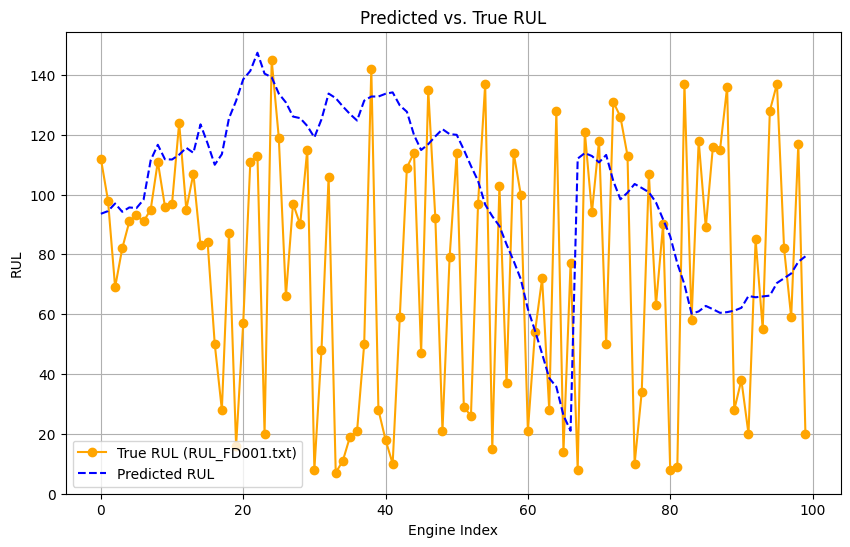

In [59]:

# RUL values from the raw RUL.txt file
true_rul = RUL[0].values 

predicted_rul = np.concatenate(all_y_pred, axis=0)[:len(true_rul)]

plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL (RUL_FD001.txt)', marker='o', color='orange')

# Plot the predicted RUL values
plt.plot(predicted_rul, label='Predicted RUL', linestyle='--', color='blue')

# Formatting the plot
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.title('Predicted vs. True RUL')
plt.legend()
plt.grid(True)
plt.show()


